In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import pystan
import pandas as pd
import stan_utility

# <center>**Flexible Models of Holiday Lift**</center>
## <center>Alex Braylan, Dan Marthaler</center>
## <center>[Revionics](http://www.revionics.com)</center>

# Abstract

Holidays often have a strong influence on time series data. Popular methods for modeling holiday effects involve using indicator variables on official holiday dates or cyclical trigonometric indicators such as Fourier transforms. However, these can often fail to capture irregular variations common among holiday effects such as offset from the official date, sharpness, flatness, or asymmetry around the peak. We introduce a model of holiday effects as a function of continuous time and parameters determining form and intensity. We implement this model in Stan and show how it infers posterior distributions explaining observed and holdout data for simulated and real examples of various forms of holiday effects. 

# Introduction

Time series often exhibit significant holiday effects: regular periods (usually yearly) during which the magnitude of observed data is affected by the proximity of an important scheduled event such as a national holiday. A robust method of modeling these effects should meet several criteria:
1. **Flexibility in general shape**. Holiday effects may suddenly spike up then disappear, or they may have long ascent/descent effects or sustained elevation. The effects may be positive or negative.
2. **Discovery of peak location**. Holiday effects may peak near but not exactly on a provided holiday date.
3. **Sparsity**. Holiday effects should be used sparingly, not to explain too much variation in the data.

One approach for modeling holidays that satisfies the first two criteria is to use indicator variables, as done by Facebook's [Prophet](https://facebook.github.io/prophet). Holiday effects occurring before or after the official holiday can be captured by having additional indicator variables within a user-specified range of dates before or after the holiday (see [https://github.com/facebook/prophet/issues/389]). However, if the holiday effect is long-lasting, growth in the number of indicator variables leads the model to overfit, especially when the data is sparse. Our approach minimizes this overfitting by calculating the effect on each date as a simple parametric function of its offset from the holiday, thereby addressing the third criterion above. We will also show how it satisfies the first two criteria.

# Holiday effect function

Our holiday effect function $H$ describes the holiday effect's magnitude (lift) at time point $t$:

## $ H(t) = 2 \lambda e^{-|z(t)|^c} \Phi\left(q z(t)\right) $

## $z(t) = \frac{t - \mu}{\sigma}$
Where
$\mu$ is the location parameter,

$\sigma$ is the scale parameter,

$c$ is the shape parameter,

$q$ is the skew parameter,

$\lambda$ is the intensity parameter, and

$\Phi(\cdot)$ normal cumulative distribution function

This is just an unnormalized generalized normal / skew normal distribution function, which allows flexibility in form:
* Can look like normal pdf
* Can look like Laplace (AKA double-exponential) pdf
* Can be asymmetrical

Note: we are not using $H(t)$ as a probability distribution, but as a functional form for lift as a function of continuous time.

Typically we place the holiday effect function within a larger model, e.g. as a component for the mean of a count distribution. Multiple holiday effects are allowed to overlap, up to a maximum number specified by the model. Using strict priors on the relatively few parameters, this function is able to express a wide variety of holiday effects without overfitting.

In [2]:
class Holiday():
    def __init__(self, lift, d, scale, shape=1, skew=0):
        assert(shape > 0)
        self.lift = lift
        self.d = d
        self.scale = scale
        self.shape = shape
        self.skew = skew
    def get_lift(self, x):
        x1 = (x-self.d)/self.scale
        return self.lift * np.exp(-np.abs(x1)**self.shape) * 2 * norm.cdf(self.skew * x1)
    def get_lift_alternate(self, x):
        x1 = (x-self.d)/self.scale
        return self.lift * 1 / (1 + np.abs(x1)**self.shape) * 2 / (1 + np.exp(-self.skew * x1))

# Simulated data

First let's look at a couple of example parametrizations of the holiday effect function to illustrate how the form varies with changes in the parameters.

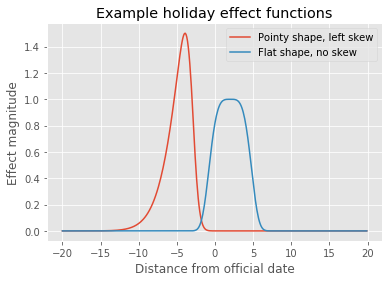

In [3]:
t = np.arange(-20, 20, 0.1)
h = Holiday(1.0, -3, 3, 1.5, -4)
h2 = Holiday(1.0, 2, 3, 4, 0)
d1, = plt.plot(t, h.get_lift(t), label="Pointy shape, left skew")
d2, = plt.plot(t, h2.get_lift(t), label="Flat shape, no skew")
plt.xlabel("Distance from official date")
plt.ylabel("Effect magnitude")
plt.title("Example holiday effect functions")
plt.legend(handles=[d1, d2])
plt.show()

Holiday effects might be part of a larger model with additional exogenous variables. In the following steps, we simulate observations conditionally dependent on both holiday effects and two independent variables: one following a stationary distribution and another following a random walk.

In [4]:
def generate_stationary(p, sig, n):
    return np.random.binomial(1,p,n) * np.random.normal(0,sig,n)

def generate_randomwalk(p, sig, n):
    return np.exp(np.cumsum(generate_stationary(p,sig,n)))

In [5]:
T_PER_YEAR = 52
n_years = 3
T = T_PER_YEAR * n_years
x1_chg_p = 1#0.05
x1_chg_sig = 0.01
x2_chg_p = 0.2
x2_chg_sig = 0.15
x1 = generate_randomwalk(x1_chg_p, x1_chg_sig, T)
x2 = generate_stationary(x2_chg_p, x2_chg_sig, T)

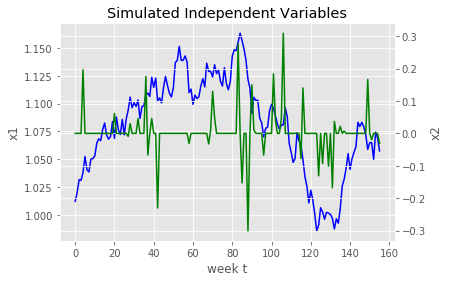

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(x1, color="b")
ax1.set_title('Simulated Independent Variables')
ax1.set_xlabel('week t')
ax1.set_ylabel('x1')
ax2 = ax1.twinx()
ax2.plot(x2, color="g")
ax2.set_ylabel('x2')
plt.show()

This simulation will generate data from a count model with a log linear form combining the holiday effect with the "baseline" linear effects from the exogenous variables.

In [7]:
class Item():
    def __init__(self, alpha, betas, holidays):
        self.alpha = alpha
        self.betas = betas
        self.holidays = holidays
    def get_days_of_year(self, length):
        return np.arange(length) % T_PER_YEAR
    def get_official_holidays(self, length):
        doy = self.get_days_of_year(length)
        return [[t for t in range(length) if doy[t] == h.d] for h in self.holidays]
    def generate_y(self, X):
        doy = self.get_days_of_year(X.shape[0])
        baseline = self.alpha + np.dot(X, self.betas)
        holiday_effect = np.sum([h.get_lift(doy) for h in self.holidays], axis=0)
        return np.random.poisson(np.exp(baseline + holiday_effect))

A list of official holiday indices supplies prior centers for the holiday effect peak locations. In this simulation, the holiday peaks are specified to occur at offsets to the official indices to reflect how holiday effects often do not peak exactly on the official dates in real life.

beta = 3.5


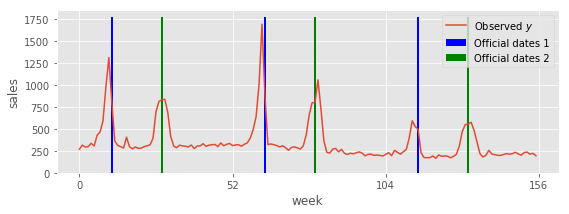

In [44]:
known_holiday_i = [7, 16, 29, 41, 50] # "known holiday dates"
holidays = []
peak_offset1 = 4
peak_offset2 = -1
holidays.append(Holiday(1.0, known_holiday_i[0] + peak_offset1, 3, 1.5, -4))
holidays.append(Holiday(1.0, known_holiday_i[2] + peak_offset2, 3, 4, 0))
item = Item(alpha=2.2, betas=[3.5, -1.2], holidays=holidays)

x1_chg_p = 0.05
x1_chg_sig = 0.03
x2_chg_p = 0.1
x2_chg_sig = 0.15
x1 = generate_randomwalk(x1_chg_p, x1_chg_sig, T)
x2 = generate_stationary(x2_chg_p, x2_chg_sig, T)
X = np.transpose(np.array([x1, x2]))
y = item.generate_y(X)
plt.figure(figsize=(9,3))
plt.xlabel('week')
plt.ylabel('sales')
# plt.title("Simulated dependent variable with holiday effect")
plt.plot(y)
ymax = plt.ylim()[1]
official_dates_per_h = item.get_official_holidays(X.shape[0])
bcolors = ["blue", "green", "yellow"]
labels = ["Observed $y$"]
for i, official_dates in enumerate(official_dates_per_h):
    plt.bar(official_dates, [ymax] * len(official_dates), color=bcolors[i])
    labels.append("Official dates " + str(i+1))
plt.legend(labels)
print("beta =", item.betas[0])
plt.xticks(np.arange(0, 157, 52))
plt.show()

Now that we have simulated the data, we will put it all in a dictionary to feed to the Stan model along with hyperparameters specifying the priors and active components of the model.

In [45]:
def create_stan_data(T, X, y, approx_holiday_peaks=[], holdout_years=0):
    if X is None:
        X = np.array([[0]] * T, dtype=float)
    K = X.shape[1]
    H = len(approx_holiday_peaks)
    stan_data = {"T":T, "K":K, "H":H, "y":y, "X":X}

    BIP = 10 # barely informative prior scale

    stan_data["alpha_prior_mu"] = np.mean(np.log(y))
    stan_data["alpha_prior_sig"] = BIP

    stan_data["beta_prior_mu"] = 0.0 * np.ones(K)
    stan_data["beta_prior_cov"] = np.diag(BIP * np.ones(K))

    stan_data["h_lift_horseshoe_scale"] = 0.001

    stan_data["h_loc_prior_mu"] = 0.0 * np.ones(H)
    stan_data["h_loc_prior_sig"] = 1.0 * np.ones(H)
    stan_data["h_scale_prior_mu"] = 2.0 * np.ones(H)
    stan_data["h_scale_prior_sig"] = 1.5 * np.ones(H)
    stan_data["h_shape_prior_mu"] = 1.5 * np.ones(H)
    stan_data["h_shape_prior_sig"] = 0.8 * np.ones(H)
    stan_data["h_skew_prior_mu"] = 0.0 * np.ones(H)
    stan_data["h_skew_prior_sig"] = 2.0 * np.ones(H)
    stan_data["overdispersion_penalty"] = 1

    stan_data["use_regressors"] = 1
    stan_data["use_neg_binomial"] = 1
    stan_data["use_h_loc"] = 1
    stan_data["use_h_shape"] = 1
    stan_data["use_h_skew"] = 1

    d_peak = []
    for approx_peak in approx_holiday_peaks:
        d = np.arange(T) % T_PER_YEAR - approx_peak
        d_peak.append(np.array([t+T_PER_YEAR if t<-T_PER_YEAR/2.0 else t-T_PER_YEAR if t>T_PER_YEAR/2.0 else t for t in d]))
    stan_data['d_peak'] = np.array(d_peak)

    stan_data["holdout_years"] = holdout_years
    if holdout_years > 0:
        n_years_approx = int(round(T / T_PER_YEAR))
        t = np.arange(T, dtype=int)
        stan_data["training_i"] = t[:-T_PER_YEAR*holdout_years] + 1
        stan_data["testing_i"] = t[-T_PER_YEAR*holdout_years:] + 1
    else:
        stan_data["training_i"] = np.arange(T, dtype=int) + 1
        stan_data["testing_i"] = np.array([], dtype=int)
    stan_data["n_training"] = len(stan_data["training_i"])
    stan_data["n_testing"] = len(stan_data["testing_i"])
    return stan_data

### Modeling main points
* A user-defined list of holidays determines the maximum number of holidays allowed and their approximate peaks.
* For each holiday, calculate the continuous temporal difference between the official (or approximate) holiday date and each time point in the data. These offsets will be inputs to the holiday effect function, allowing the official holiday date to be the prior mode of the peak location.
* Each holiday gets its own holiday effect function with its own parameters. Total holiday lift is the sum over all holidays.
* Time points of observed data need not occur at a fixed interval, but do so in these examples.
* Place reasonable priors on the parameters of the holiday effect functions. The ones supplied above are demonstrated to work well.
* Place [horseshoe prior](http://proceedings.mlr.press/v5/carvalho09a.html) ([blog post](https://web.archive.org/web/20160405001356/https://ariddell.org/horseshoe-prior-with-stan.html)) on holiday lift. Doing so encourages sparsity and resists using holidays to explain minor variation in the data.
* In this demo, holiday lift centered at zero is exponentiated and multiplied to the rest of the model, allowing holidays to add or subtract peaks from, for example, a regression output.

**Hint**: use non-zero locations of scale and shape priors. If the holiday effect samples are too "pointy" when the location parameter is off, the sampler will have difficulty moving to better values of the location parameter.

**Extra hint**: if you believe multiple holidays should look similar to each other, you could put hierarchical priors on their parameters (e.g. scale, shape, etc.).

In [46]:
stan_model_code = """
data {
    // OBSERVATIONS
    int<lower=1> T; // number of dates
    int<lower=0> K; // number of covariates
    int<lower=0> H; // number of holidays
    int<lower=0> y[T];
    matrix[T, K] X;
    matrix<lower=-27, upper=27>[H, T] d_peak; // distance (in time) from holiday
    
    // HOLDOUT SPLIT
    int<lower=1, upper=T> n_training;
    int<lower=0, upper=T> n_testing;
    int<lower=1, upper=T> training_i[n_training];
    int<lower=1, upper=T> testing_i[n_testing];
    
    // HYPERPARAMETERS
    real alpha_prior_mu; // initialize at log mean y
    real<lower=0> alpha_prior_sig;
    vector[K] beta_prior_mu;
    matrix[K, K] beta_prior_cov;
    real<lower=0> h_lift_horseshoe_scale;
    vector[H] h_loc_prior_mu;
    vector<lower=0>[H] h_loc_prior_sig;
    vector[H] h_scale_prior_mu;
    vector<lower=0>[H] h_scale_prior_sig;
    vector[H] h_shape_prior_mu;
    vector<lower=0>[H] h_shape_prior_sig;
    vector[H] h_skew_prior_mu;
    vector<lower=0>[H] h_skew_prior_sig;
    real<lower=0> overdispersion_penalty;
    int use_regressors;
    int use_neg_binomial;
    int use_h_loc;
    int use_h_shape;
    int use_h_skew;
}
parameters {
    real alphaZ;
    vector[K] betaZ;
    
    vector<lower=0>[H] h_lift;
    vector<lower=0>[H] h_lift_local; // horseshoe prior
    real<lower=0> h_lift_global;
    
    vector[H] h_locZ;
    vector<lower=0>[H] h_scaleZ;
    vector<lower=-1>[H] h_shapeZ;
    vector[H] h_skewZ;
    
    real<lower=0.01, upper=0.8> invphi;
}
transformed parameters {
    vector[T] baseline;
    vector[T] holiday_effect;

    real alpha;
    vector[K] beta;
    
    vector[H] h_loc;
    //vector<lower=0, upper=10>[H] h_scale;
    //vector<lower=0, upper=5>[H] h_shape;
    //vector<lower=-10, upper=10>[H] h_skew;
    vector<lower=0>[H] h_scale;
    vector<lower=0>[H] h_shape;
    vector[H] h_skew;
    
    // PRIOR REPARAMETRIZATION
    alpha = alpha_prior_mu + alpha_prior_sig * alphaZ;
    for(k in 1:K)
        beta[k] = beta_prior_mu[k] + beta_prior_cov[k, k] * betaZ[k]; // diagonal covariance
    h_loc = h_loc_prior_mu + h_loc_prior_sig .* h_locZ;
    h_scale = h_scale_prior_mu + h_scale_prior_sig .* h_scaleZ;
    h_shape = h_shape_prior_mu + h_shape_prior_sig .* h_shapeZ;
    h_skew = h_skew_prior_mu + h_skew_prior_sig .* h_skewZ;

    for(t in 1:T) {
        baseline[t] = alpha; // INTERCEPT
        holiday_effect[t] = 0;
    }
    // REGRESSION ON COVARIATES
    if(use_regressors)
        baseline += X * beta;
    // HOLIDAY LIFT
    for(h in 1:H) {
        real loc = use_h_loc ? h_loc[h] : 0;   // switch to use location parameter
        real c = use_h_shape ? h_shape[h] : 1; // switch to use shape parameter
        real q = use_h_skew ? h_skew[h] : 0; // switch to use skew parameter
        real lambda = h_lift[h] * h_lift_horseshoe_scale * h_lift_local[h] * h_lift_global;
        for(t in 1:T) {
            real z = (d_peak[h, t] - loc) / h_scale[h];
            real tdd = lambda * exp(-fabs(z)^c);
            if(use_h_skew)
                tdd *= 2 * normal_cdf(q * z, 0, 1);
            holiday_effect[t] += tdd;
        }
    }
}
model {
    // PRIORS
    alphaZ ~ normal(0, 1);
    betaZ ~ normal(0, 1);
    h_lift ~ normal(0, 1);
    h_lift_local ~ cauchy(0, 1);
    h_lift_global ~ normal(0, 1);
    h_locZ ~ normal(0, 1);
    h_scaleZ ~ normal(0, 1);
    h_shapeZ ~ normal(0, 1);
    h_skewZ ~ normal(0, 1);
    invphi ~ beta(1, overdispersion_penalty);
    
    // LIKELIHOOD
    for(n in 1:n_training) {
        int t = training_i[n];
        real log_count_mean = baseline[t] + holiday_effect[t];
        if(use_neg_binomial) {
            y[t] ~ neg_binomial_2_log(log_count_mean, 1.0/invphi);
        }
        else {
            y[t] ~ poisson_log(log_count_mean);
        }
    }
}
"""

In [35]:
stan_model = pystan.StanModel(model_code=stan_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a915b039df957646642a706dfab6d0e6 NOW.


In [47]:
# no holdout for this simulated data
stan_data = create_stan_data(T, X, y, known_holiday_i)

In [48]:
stan_op = stan_model.optimizing(data=stan_data,verbose=True,init='0',refresh=1)
n_chains = 2
max_depth = 13
adapt_delta = 0.9
stan_fit = stan_model.sampling(data=stan_data, iter=1000, chains=n_chains, init=[stan_op]*n_chains,
                                   control=dict(max_treedepth=max_depth, adapt_delta=adapt_delta))

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Diagnostics

In [49]:
stan_utility.check_n_eff(stan_fit)
stan_utility.check_rhat(stan_fit)
stan_utility.check_treedepth(stan_fit, max_depth)
stan_utility.check_energy(stan_fit)
stan_utility.check_div(stan_fit)

n_eff / iter looks reasonable for all parameters
Rhat for parameter invphi is nan!
Rhat for parameter holiday_effect[22] is nan!
Rhat for parameter holiday_effect[34] is nan!
Rhat for parameter holiday_effect[35] is nan!
Rhat for parameter holiday_effect[74] is nan!
Rhat for parameter holiday_effect[86] is nan!
Rhat for parameter holiday_effect[87] is nan!
Rhat for parameter holiday_effect[126] is nan!
Rhat for parameter holiday_effect[138] is nan!
Rhat for parameter holiday_effect[139] is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0 of 1000 iterations saturated the maximum tree depth of 13 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 1000 iterations ended with a divergence (0.0%)


There may be some nan-valued Rhats. When examining the fit parameters, if the n_eff is not nan then the issue is likely [arithmetic precision error](https://groups.google.com/forum/#!topic/stan-users/hn4W_p8j3fs) rather than a modeling or sampling problem.

In [50]:
stan_fit

Inference for Stan model: anon_model_a915b039df957646642a706dfab6d0e6.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alphaZ               -0.35  5.8e-4   0.02  -0.39  -0.36  -0.35  -0.34  -0.32    797    1.0
betaZ[0]              0.35  6.0e-4   0.02   0.32   0.34   0.35   0.36   0.38    794    1.0
betaZ[1]              -0.1  6.0e-4   0.02  -0.14  -0.12   -0.1  -0.09  -0.07   1000    1.0
h_lift[0]             1.21    0.02   0.67   0.24   0.72   1.08    1.6   2.85   1000    1.0
h_lift[1]             0.79    0.02   0.58   0.04   0.34   0.65   1.13   2.13   1000    1.0
h_lift[2]             1.22    0.02   0.68   0.18   0.71   1.14   1.64   2.81    791    1.0
h_lift[3]             0.78    0.02    0.6   0.02    0.3   0.67   1.13   2.22   1000    1.0
h_lift[4]             0.81    0.02   0.61   0.04   0.33   0.68   1.16   2.26   1000  

Common practice is to examine the posterior samples of the model parameters. Generally we want the posterior to contain the "true" parameters used in simulation.

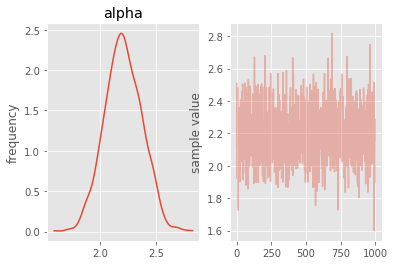

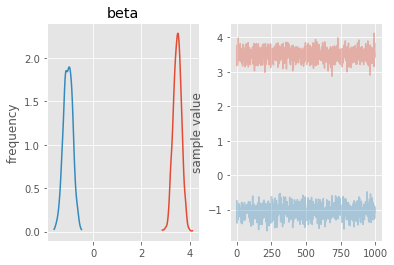

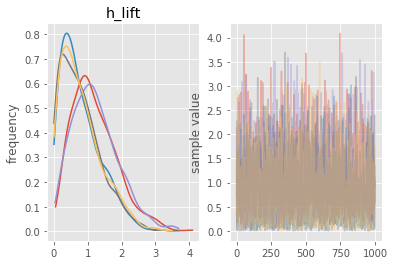

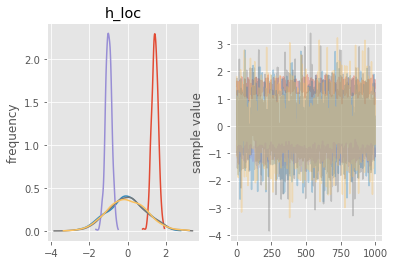

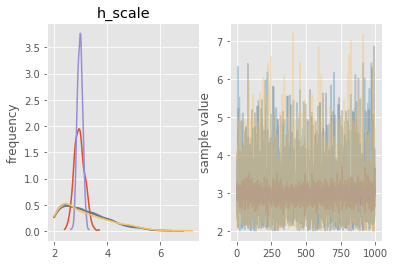

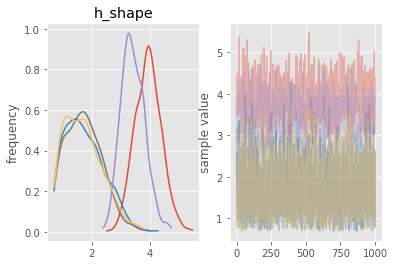

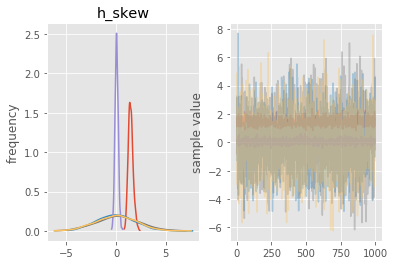

In [51]:
for par in ['alpha', 'beta', 'h_lift', 'h_loc', 'h_scale', 'h_shape', 'h_skew']:
    stan_fit.plot([par]);
plt.show()

Additionally, we backtest our fitted model predictions against the observed data. Here we do this by looking at posterior samples of the mean of the final distribution (in this case Poisson or negative binomial) from which the observed $y$ values are assumed to be generated. However, we could alternatively look at actual draws from the final distribution if we collected these in a `generated quantities` block in the Stan model code.

In [52]:
def plot_y_means(n_years, stan_data, samples, tt=None):
    cols = 2
    rows = int(np.ceil(n_years / cols))
    
    f, axarr = plt.subplots(rows, cols, sharex=False, sharey=True, figsize=(9, 3*rows))
    
    for year in range(n_years):
        inds = np.arange(0, T_PER_YEAR) + year * T_PER_YEAR
        if tt is None:
            x = inds
        else:
            x = tt[inds]
        ax = axarr[int(year/cols), year%cols]
        for s in range(samples["holiday_effect"].shape[0]):
            pred, = ax.plot(x,np.exp(samples["baseline"][s][inds] + samples["holiday_effect"][s][inds]), 
                            color="blue", alpha=0.1, label="model")
        actual, = ax.plot(x,stan_data["y"][inds], color="red", linewidth=2, alpha=0.9, label="actual")
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        if tt is None and int(year/cols) == int(n_years/cols):
            ax.set_xlabel('Time')
        title = "Year " + str(year+1)
        if year >= n_years - stan_data["holdout_years"]:
            title += " (HOLDOUT)"
        ax.set_title(title)
        ax.legend(handles=[pred, actual], fancybox=True, framealpha=0.2, loc="best")
    if n_years%2 == 1:
        f.delaxes(axarr[int(n_years/cols)][1])
    f.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

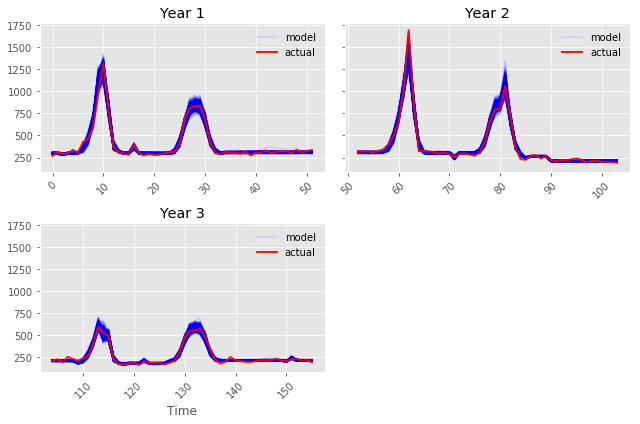

In [53]:
samples = stan_fit.extract()
plot_y_means(3, stan_data, samples)

# Real data
We use free data downloaded from [Google Trends](http://trends.google.com) for several search words exhibiting interesting holiday effects. Each term returns five years of data at weekly granularity. We train on the first three years and use the final two years as holdout. We also use a list of official holidays to preprocess the data (see below).

In [54]:
holiday_list = pd.read_csv("holiday_dates.csv", parse_dates=[3])
hol_ids = holiday_list["HolidayId"].unique()

### List of official holiday dates for 2018
The official holiday list imposes the maximum number of holidays and specifies the prior location for the peak of each holiday on each year.

In [46]:
holiday_list[holiday_list.HolidayDate.dt.year==2018].tail()

,Unnamed: 0,HolidayId,holidayname,HolidayDate
144,144,7,Memorial Day,2018-05-28
165,165,8,Mothers Day,2018-05-13
186,186,9,New Years,2018-01-01
207,207,10,Thanksgiving,2018-11-22
228,228,11,Valentines Day,2018-02-14


### List of official holiday dates for Easter
Some holidays fall on different dates on different years. If these dates are known in advance, they can be used to center the holiday effect correctly on each year.

In [47]:
holiday_list[holiday_list.holidayname=="Easter"].tail()

,Unnamed: 0,HolidayId,holidayname,HolidayDate
37,37,2,Easter,2016-03-27
38,38,2,Easter,2017-04-16
39,39,2,Easter,2018-04-01
40,40,2,Easter,2019-04-21
41,41,2,Easter,2020-04-12


In [72]:
def create_stan_data_from_trendcsv(csvname):
    df = pd.read_csv(csvname, header=1, names=["week","count"], parse_dates=[0])
    T = len(df)
    X = None
    y = df["count"].values
    nearest = lambda x, v: (np.abs(v-x)).argmin()
    daysdiff = lambda x, v: (x - v[nearest(x, v)]) / np.timedelta64(1, 'D')
    stan_data = create_stan_data(T, X, y, np.zeros(len(hol_ids)), holdout_years=2)
    d_peak = []
    # get difference from official date in days for each holiday
    for hol_id in hol_ids:
        dfh = holiday_list[holiday_list["HolidayId"]==hol_id]
        i = [daysdiff(d, dfh["HolidayDate"].values) for d in df["week"].values]
        d_peak.append(i)
    stan_data["d_peak"] = np.asarray(d_peak) / 7
    return stan_data, df.week

## Keyword: [Chocolate](https://trends.google.com/trends/explore?date=today%205-y&q=chocolate)

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


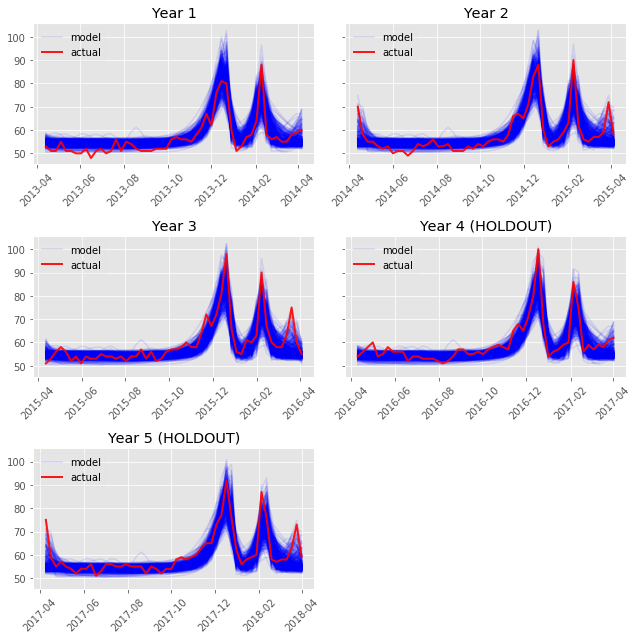

In [74]:
stan_data, sdu = create_stan_data_from_trendcsv("chocolate.csv")
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

*Question*: why does the model (correctly) predict the last peak in mid March on some years and in early April on other years?

*Answer*: for some holidays (e.g. Easter), the official date varies from year to year.

## Keyword: [Last minute gift](https://trends.google.com/trends/explore?date=today%205-y&q=last%20minute%20gift)

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


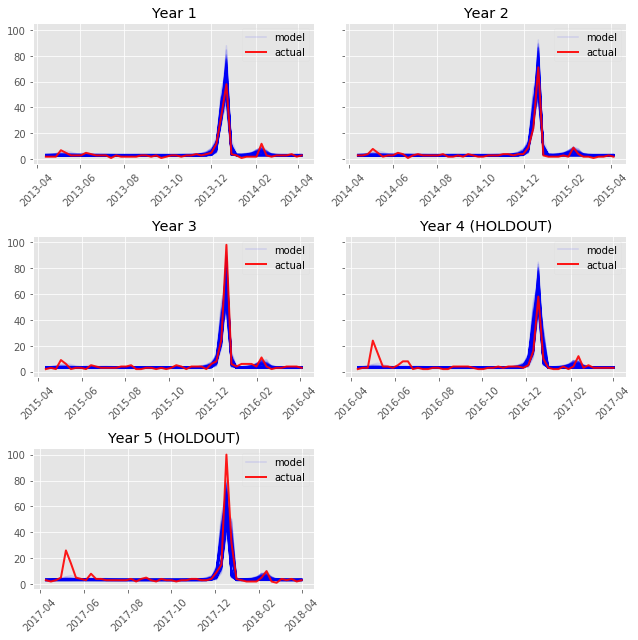

In [75]:
stan_data, sdu = create_stan_data_from_trendcsv("last_minute_gift.csv")
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

## Keyword: [Fireworks](https://trends.google.com/trends/explore?date=today%205-y&q=fireworks)

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


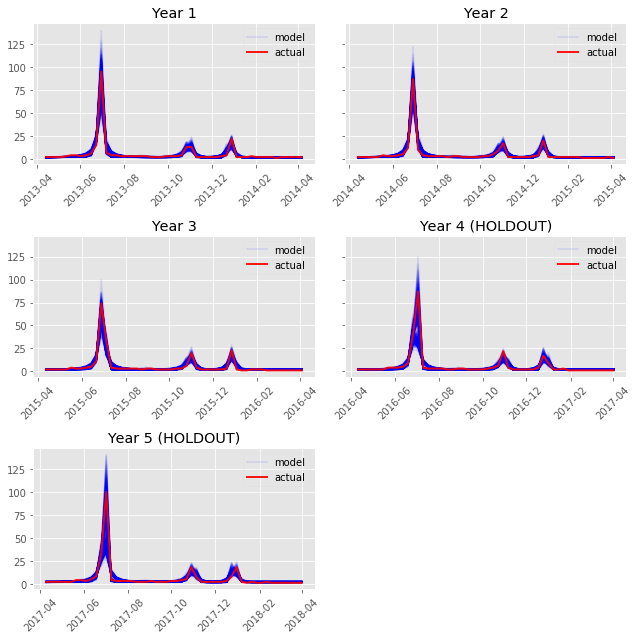

In [76]:
stan_data, sdu = create_stan_data_from_trendcsv("fireworks.csv")
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

## Keyword: [Turkey](https://trends.google.com/trends/explore?date=today%205-y&q=turkey)

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


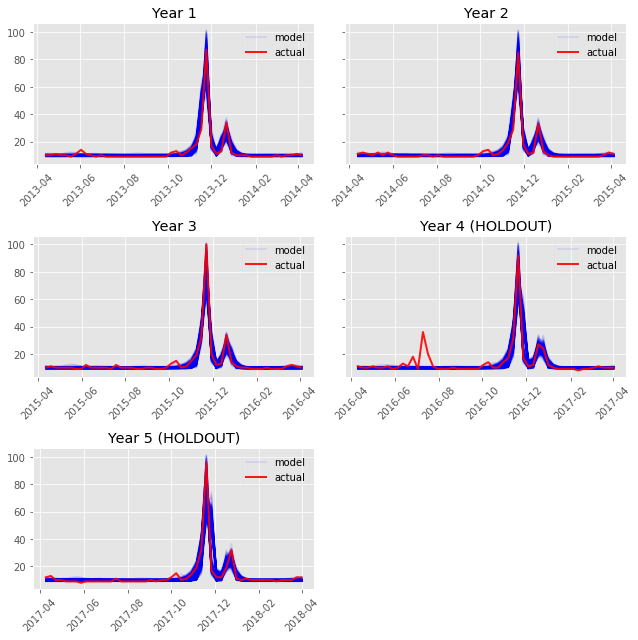

In [85]:
stan_data, sdu = create_stan_data_from_trendcsv("turkey.csv")
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2,
                              control=dict(max_treedepth=max_depth, adapt_delta=adapt_delta))
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

For some examples such as this one, the observed peak intensity or location may change year over year.  Exogenous variables, auto-regressive, or trend components could be introduced to capture this, though not done here.

## Keyword: [Pumpkin](https://trends.google.com/trends/explore?date=today%205-y&q=pumpkin)

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


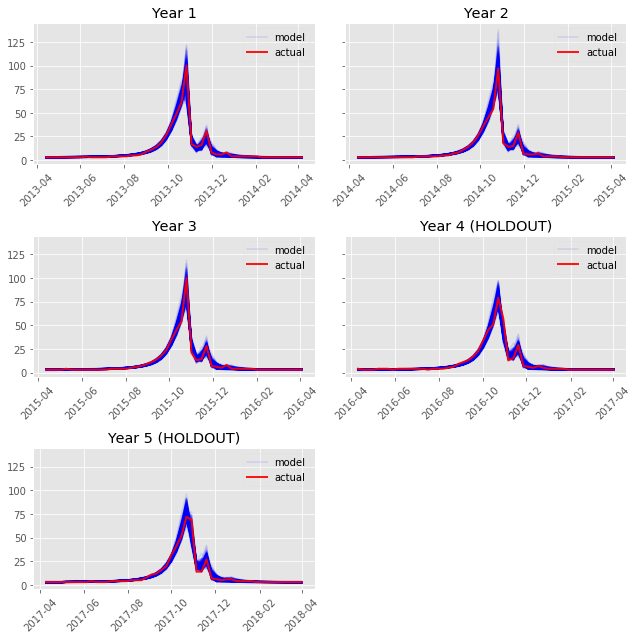

In [78]:
stan_data, sdu = create_stan_data_from_trendcsv("pumpkin.csv")
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

## Keyword: [Pumpkin Spice](https://trends.google.com/trends/explore?date=today%205-y&q=pumpkin%20spice)

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


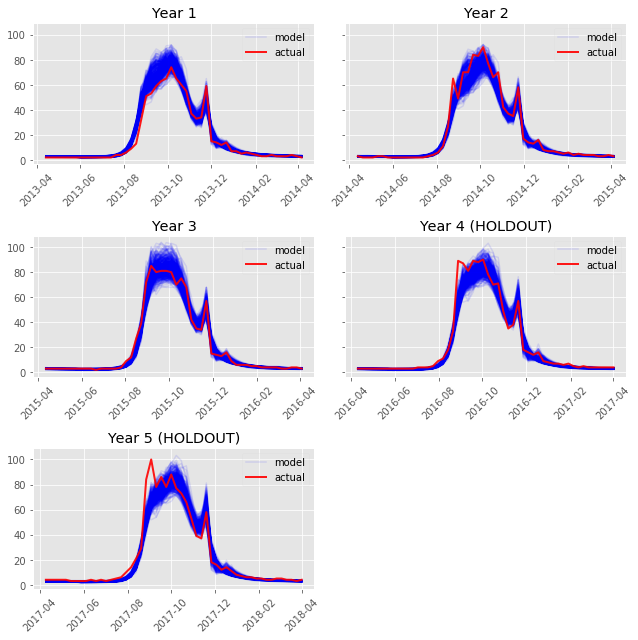

In [79]:
stan_data, sdu = create_stan_data_from_trendcsv("pumpkin_spice.csv")
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

# Simpler models
We conclude by looking at what the performance would be for the last two examples if the model were simplified by fixing the location, shape, and skew parameters at 0, 1, and 0, respectively. Freezing these parameters effectively makes the holiday effect function look just like a Laplace / double-exponential pdf forced to peak on the official holidays.

## Keyword: [Pumpkin](https://trends.google.com/trends/explore?date=today%205-y&q=pumpkin) - Simplified Model

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


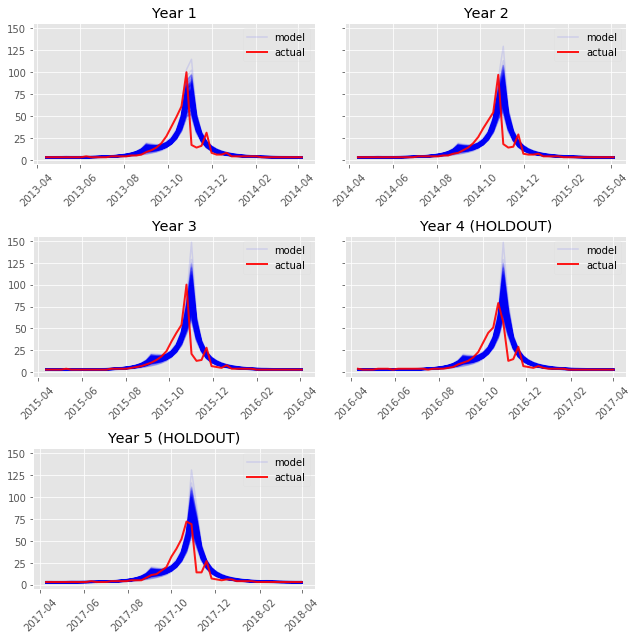

In [80]:
stan_data, sdu = create_stan_data_from_trendcsv("pumpkin.csv")
stan_data["use_h_loc"] = 0
stan_data["use_h_shape"] = 0
stan_data["use_h_skew"] = 0
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

With no location parameter, the maximum holiday effect must take place on a holiday from the holiday list.  We can see that the closest holiday corresponding to the data peaks is Halloween, but the maximal search occurs before that date.  Furthermore, with no skew parameter, the asymmetric value of the search cannot be represented. Instead, a symmetric peak is the best fit for the model. 

## Keyword: [Pumpkin spice](https://trends.google.com/trends/explore?date=today%205-y&q=pumpkin%20spice) - Simplified Model

/Users/alexbraylan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


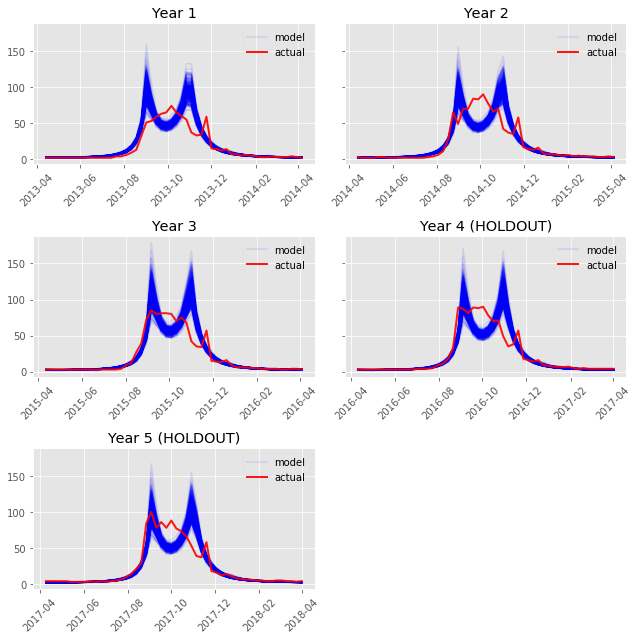

In [81]:
stan_data, sdu = create_stan_data_from_trendcsv("pumpkin_spice.csv")
stan_data["use_h_loc"] = 0
stan_data["use_h_shape"] = 0
stan_data["use_h_skew"] = 0
stan_fit = stan_model.sampling(data=stan_data, iter=500, chains=2)
samples = stan_fit.extract()
plot_y_means(5, stan_data, samples, sdu)

The model is attemping to fit using two holidays:  Labor Day and Halloween.  The probable causal reasoning behind the increase for this search term is the introduction yearly of a "Pumpkin Spice Latte" from Starbucks.  Of course, this "holiday" is not in the list!

# Conclusion
We have demonstrated a model that fits a holiday effect for a variety of scenarios. Generally, one would like to provide a superset of holidays and have the model determine which are appropriate in scope. The placement of a horseshoe prior on the holiday intensity provides this and is useful for preventing overfitting in a combined model.  The variable location, scale, shape, and skew parameters allow for automatically learning when and how the holiday effect unfolds.

This model can be a powerful element in determining temporal effects in various settings. PyStan has made it easy to develop and refine and remains our preferred method of deployment on real scenarios.

License: CC BY 4.0